# Task Solution

### Importing necessary `python` libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

import torch
from torch_geometric.data import Data

### For reproducibility

In [2]:
# Reproducibility & Config
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

### Loading the dataset

In [3]:
# Load node features and labels
content_path = "cora/cora.content"
content = pd.read_csv(content_path, sep='\t', header=None)

# Load citation links
cites_path = "cora/cora.cites"
edges = pd.read_csv(cites_path, sep='\t', header=None)

### Pre-processing

In [4]:
# Assign column names
features = content.iloc[:, 1:-1].values
labels = content.iloc[:, -1].values
paper_ids = content.iloc[:, 0].values

# Map node to label name (original class label)
index_to_label = {i: label for i, label in enumerate(labels)}  # e.g., 0: 'Neural_Networks'

In [5]:
# Map paper_id to index
paper_id_to_index = {pid: idx for idx, pid in enumerate(paper_ids)}

edges = edges.applymap(lambda x: paper_id_to_index.get(x, -1))
edges = edges[(edges != -1).all(axis=1)].values  # Remove missing links
edges[edges[:, 0] == 163][:5], edges[edges[:, 0] == 163].shape

C:\Users\kaleem\AppData\Local\Temp\ipykernel_40768\435071355.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  edges = edges.applymap(lambda x: paper_id_to_index.get(x, -1))


(array([[ 163,  402],
        [ 163,  659],
        [ 163, 1696],
        [ 163, 2295],
        [ 163, 1274]]),
 (166, 2))

### Exploratory Data Analysis (EDA)

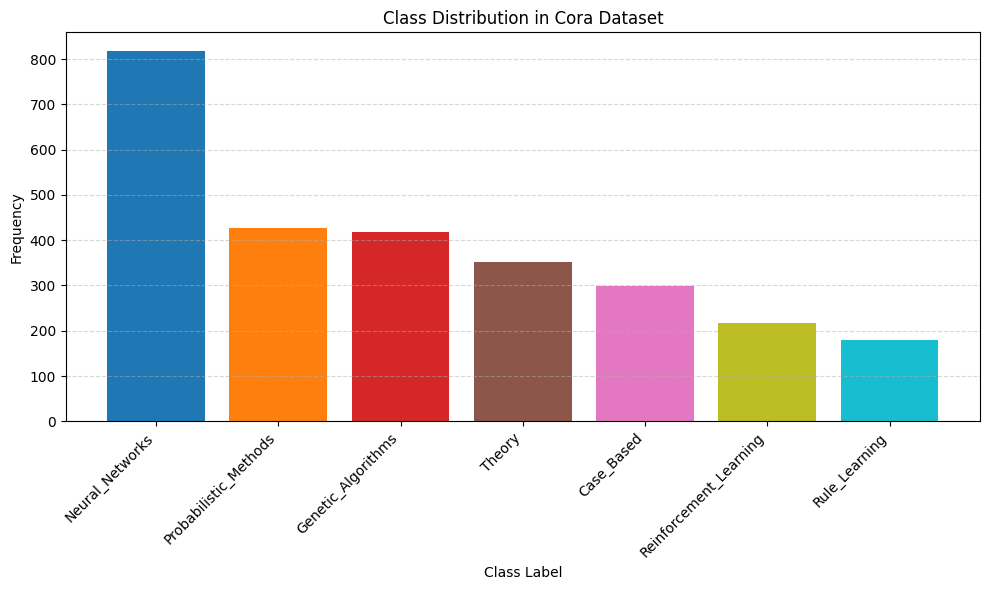

In [6]:
from viz import plot_class_distribution, plot_citation_graph, plot_citation_subgraph

# Example usage
plot_class_distribution(labels, dataset_name="Cora Dataset")

It can be seen that there is a multi-class problem where `Neural Networls` class is pretty frequent and dominates other classes.

In [7]:
# Encode string labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [8]:
# Converting to PyTorch tensors
X = torch.tensor(features, dtype=torch.float)
Y = torch.tensor(labels_encoded, dtype=torch.long)
edge_index = torch.tensor(edges.T, dtype=torch.long)

# Creating PyG Data object
data = Data(x=X, edge_index=edge_index, y=Y)

In [9]:
data

Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708])

| **Description** | **Details** |
|-----------------|-------------|
| **Nodes**       | 2708 scientific papers, each with 1433 features (e.g., word presence in the paper) |
| **Edges**       | 5429 directed edges, represented in COO format with the shape `[2, 5429]` |
| **Labels**      | 2708 labels, one per paper, representing the subject class |

### Graph Visualization

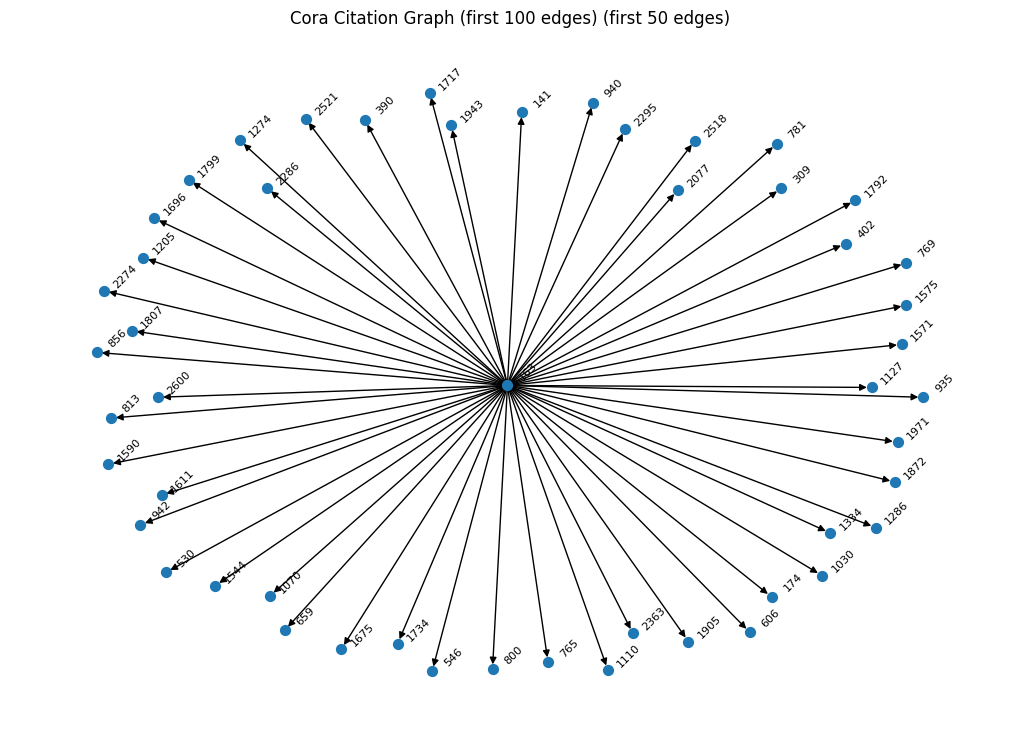

In [10]:
plot_citation_graph(edges, num_edges=50, dataset_name="Cora Citation Graph (first 100 edges)")

This plot displays a small portion of the Cora citation graph, specifically the first 50 edges. It highlights node 163 as a central hub, citing or being cited by 99 other papers, showcasing its significant connectivity within this sub-graph.

##### Plotting Subgraphs to visualise the connections between paper citing and cited.

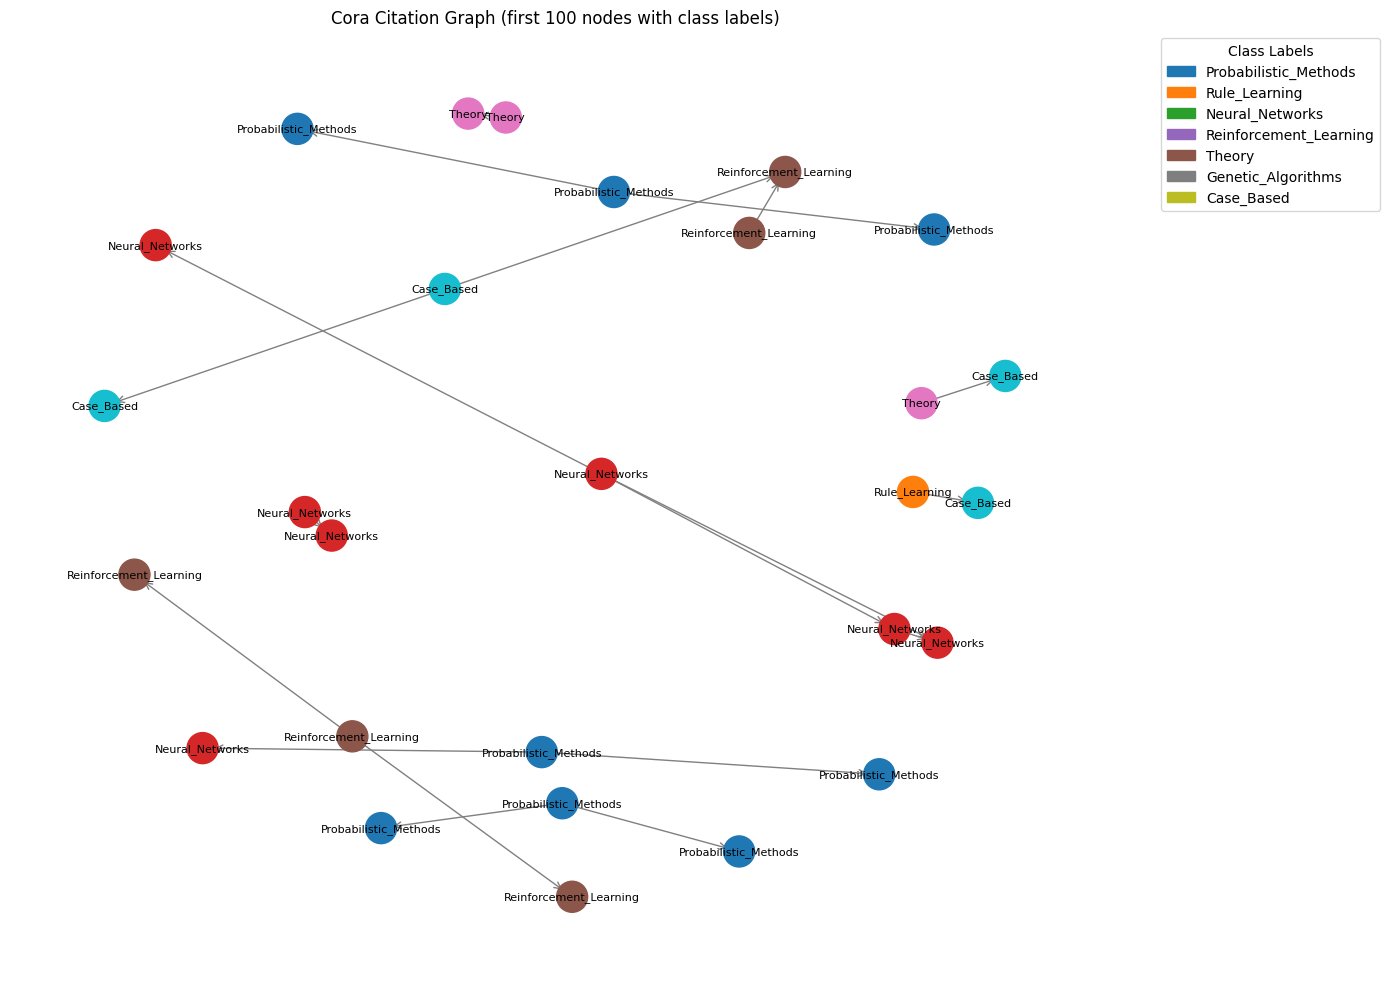

In [11]:
plot_citation_subgraph(edges, labels, subset_size=100, dataset_name="Cora Citation Graph")

This plot visualizes a subgraph of the Cora dataset, showing the first 100 nodes. Nodes are colored according to their scientific subject (e.g., Neural_Networks, Probabilistic_Methods), and edges represent citations. This allows for visual inspection of how different research areas connect and cluster.

##### Save Predictions to File

In [12]:
def save_predictions(predictions, filename):
    with open(filename, "w") as f:
        for idx, label in enumerate(predictions):
            f.write(f"{paper_ids[idx]}\t{index_to_label[label]}\n")

In [13]:
X.shape, Y.shape

(torch.Size([2708, 1433]), torch.Size([2708]))

### Base Model: Logistic Regression

Model Accuracy: 77.58%
Model F1-Score: 75.54%


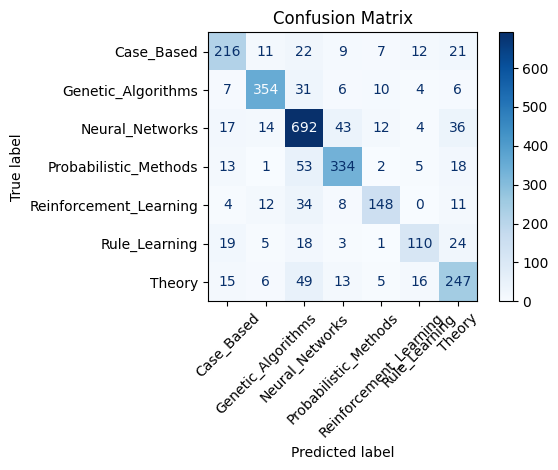

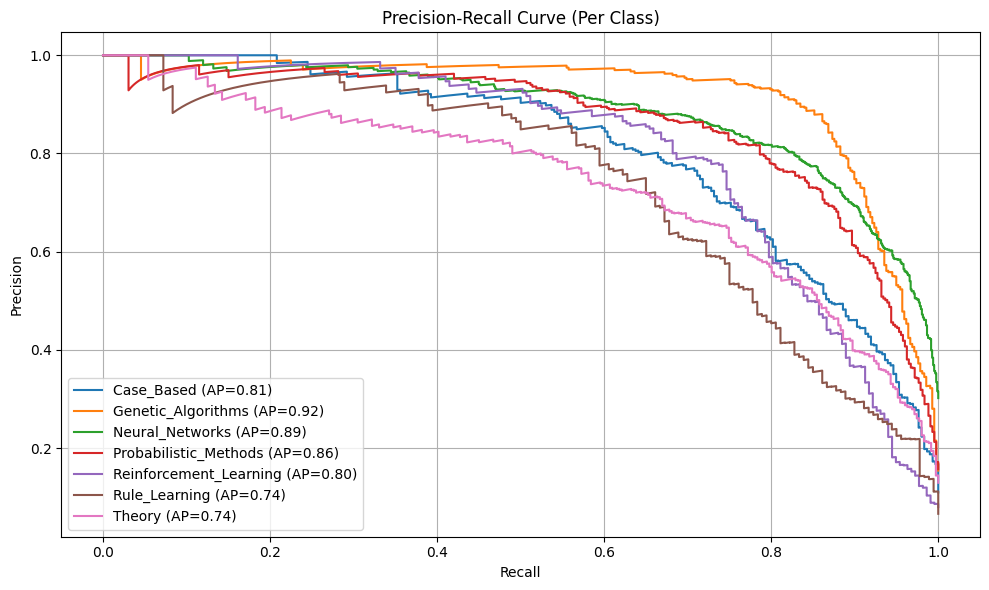

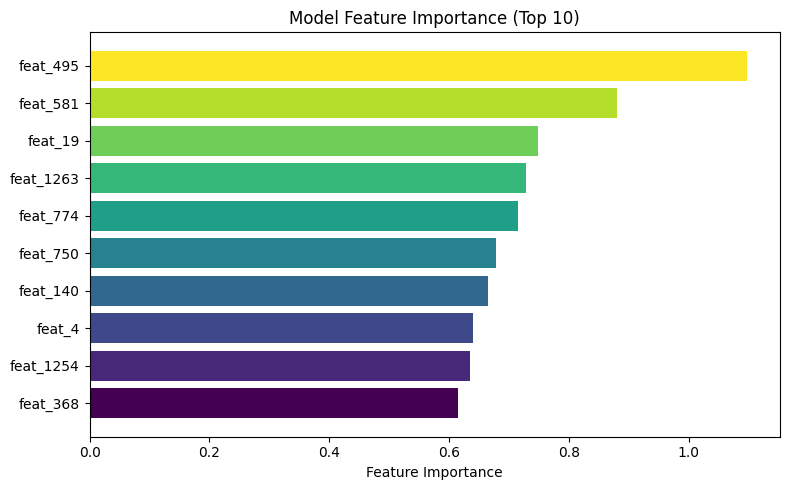

In [14]:
# Logistic Regression Model
from data_preparation import prepare_data
from train import train_logistic_regression
from evaluate import evaluate_model
max_iterations = 1000
y = Y.numpy()
skf = prepare_data(X, y)
preds_lr, probas_lr, acc, f1, clf = train_logistic_regression(X, y, skf, max_iterations)
evaluate_model(y, preds_lr, probas_lr, clf, labels)

This confusion matrix for Logistic Regression shows the model's performance in classifying scientific papers. The diagonal values represent correct predictions (e.g., `692` Neural_Networks papers correctly identified).

The bar plot displays the top 10 most important features for the Logistic Regression model, indicating which words (features) from the dictionary have the strongest influence on predicting the subject of a scientific paper. `feature_495` and `feature_581` appear to be particularly impactful.

For only 1000 iterations, it has performed fairly enough to classify the publications. `Feature 495` is very impactful in classifying the publications.

### Random Forest

Random Forest Accuracy: 76.70%
Random Forest F1-Score: 74.95%


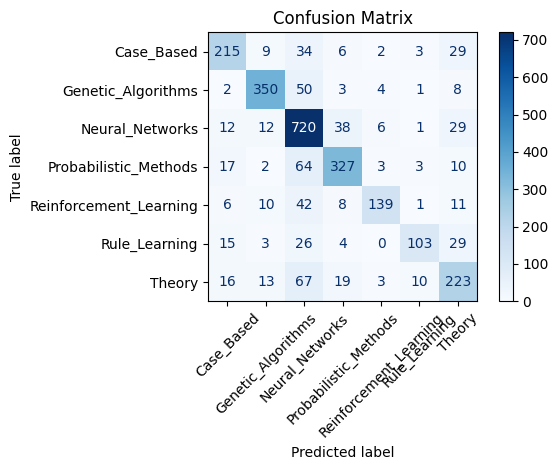

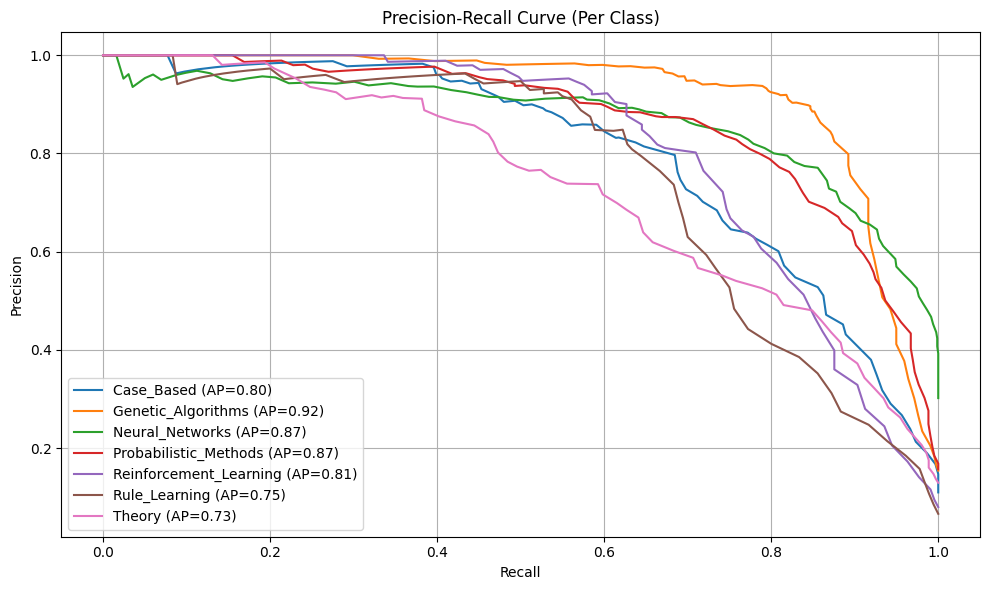

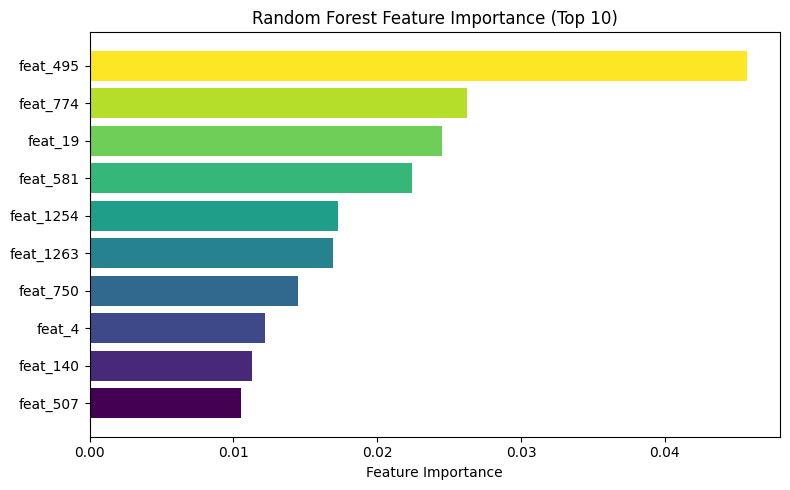

In [15]:
from train import train_random_forest
from evaluate import evaluate_model

max_iterations = 1000
n_estimators = 100
skf = prepare_data(X, y)

# Random Forest
preds_rf, probas_rf, acc_rf, f1_rf, clf_rf = train_random_forest(X, y, skf, n_estimators)
evaluate_model(y, preds_rf, probas_rf, clf_rf, labels, model_name="Random Forest")

The Random Forest model demonstrates robust performance, exhibiting high accuracy on the diagonal elements (correct classifications), particularly for Neural_Networks. Misclassifications are distributed, indicating the model generally distinguishes subjects well.

`Random Forest`, using the same number of iterations and `100 estimators`, has nearly matched the performance of `Logistic Regression`.
Likewise, `Feature 495` remains influential in the base model, though it has an even greater impact here.

### Graph Convolutional Networks

In [16]:
# Hyperparameters
num_epochs = 150

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
GCN Accuracy: 86.45%
GCN F1-Score: 85.69%


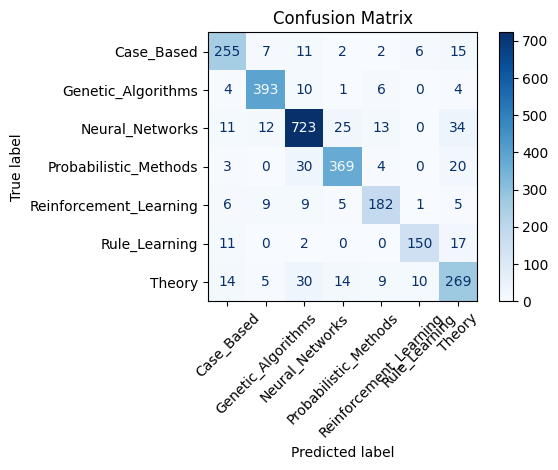

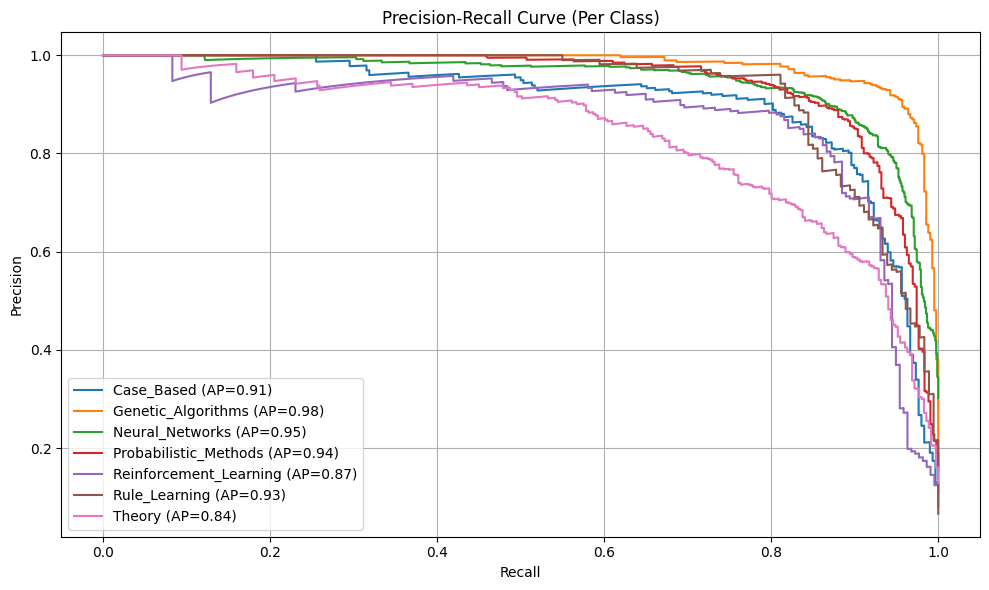

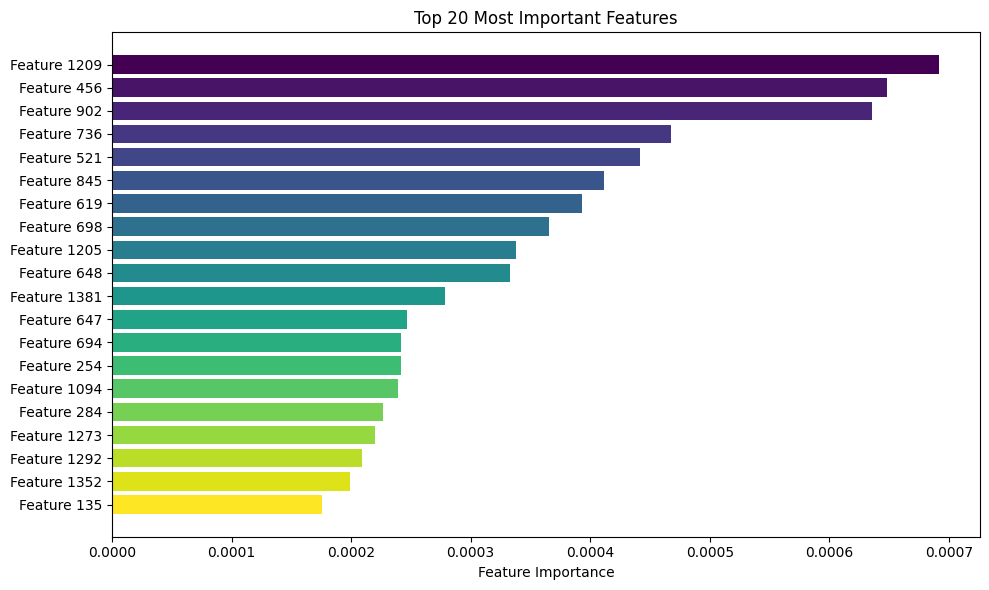

In [17]:
from data_preparation import prepare_splits
from train import train_gcn
from evaluate import evaluate_gcn
from viz import explain_gcn

# Prepare Data Splits
masks = prepare_splits(data, data.y)

# Train GCN Model
#print(preds_gcn.dtype, pred.dtype)
preds_gcn, probas_gcn, acc_gcn, f1_gcn, model_gcn = train_gcn(data, masks, num_epochs)

# Evaluate Model
evaluate_gcn(data, preds_gcn, probas_gcn, model_gcn, labels)

# Explainability
explain_gcn(data, model_gcn, node_idx=0)

The **Graph Convolutional Network (GCN)** outperformed all previously discussed models within **150 epochs**. It is particularly effective in domains such as **citation networks**, **social networks**, and **biological molecule classification**, due to its ability to efficiently aggregate neighborhood information and capture relational patterns.

The GCN's **confusion matrix** indicates strong performance, with high diagonal values (e.g., **723** for *Neural_Networks*), reflecting accurate classification across most categories. This demonstrates the advantage of leveraging graph structure in prediction tasks.

The bar chart displays the top 20 most important features for the **GCN model**. Features such as **Feature 1209** and **Feature 456** show the highest importance, indicating that certain words or word combinations play a key role in the model's classification decisions.

### Graph Attention Networks

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
GAT Accuracy: 87.08%
GAT F1-Score: 86.28%


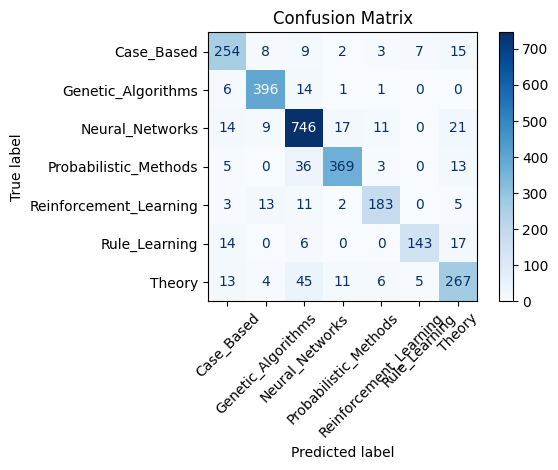

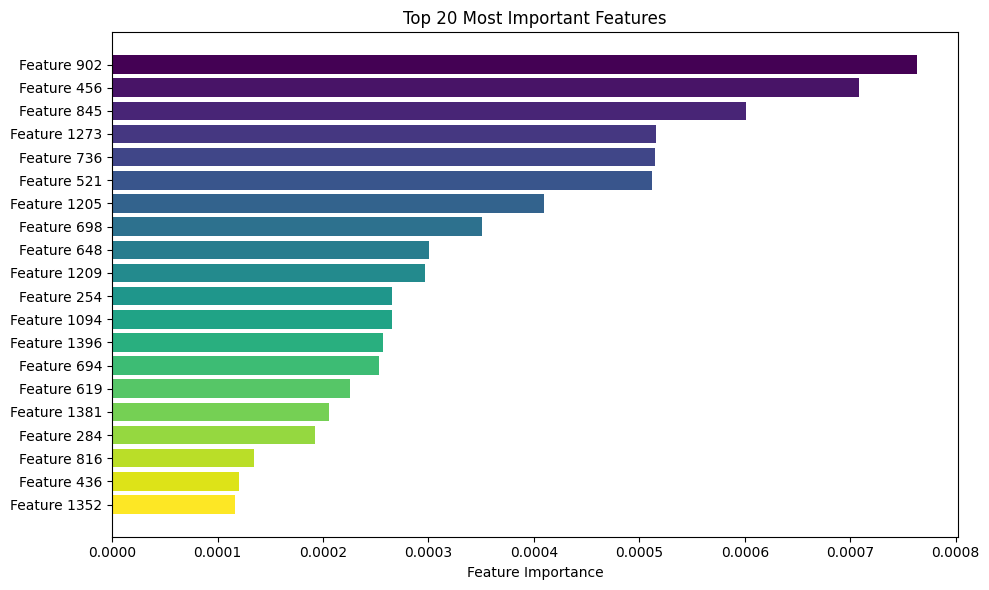

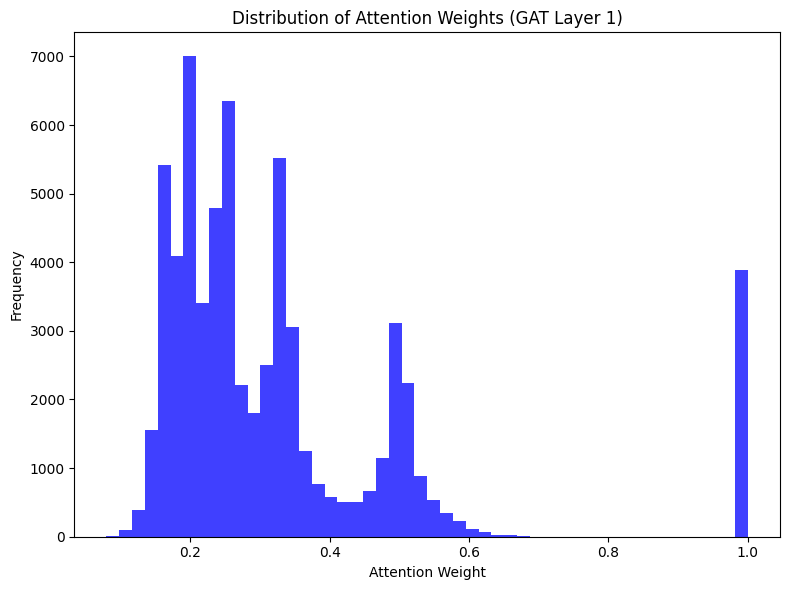

In [18]:
from train import train_gat
from evaluate import evaluate_gat
from viz import explain_gat, plot_attention_weights

# Prepare Data Splits
masks = prepare_splits(data, data.y)

# Train GAT Model
preds_gat, acc_gat, f1_gat, model_gat = train_gat(data, masks, num_epochs)

# Evaluate & Explain Model
evaluate_gat(data, preds_gat, model_gat, labels)

`Graph Attention Network` has outperformed all the models used by improving both the evaluation metrics (i.e. Accuracy and F1-Score).
It has performed well in classifying categories like *Neural_Networks* and *Genetic_Algorithms*. Higher confusion in *Theory* and *Rule Learning* suggests potential for improvement in distinguishing closely related classes.

### Conclusion

The **GCN** and **GAT** models significantly outperform traditional classifiers like **Logistic Regression** and **Random Forest**, achieving over **86% accuracy** and **F1-score** on the **CORA dataset**. **GAT** slightly outperforms **GCN**, demonstrating the effectiveness of **attention mechanisms** in capturing complex node relationships.

By leveraging graph structure, both models highlight the strength of **graph-based deep learning** for accurate **node classification** in structured data.

In [19]:
!pip freeze > requirements.txt

### 